# Predicting defective products - ASML

## Understanding the raw dataset and Performing feature engineering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data_raw = pd.read_csv('xl_data_science.csv')
data_raw.head()

,f1,f2,f3,f4,f5,f6,f7,f8,target
0,4.108216,33.094774,15.821643,-1.102204,25.651303,6.733467,-1.102204,5.991984,1277.312928
1,16.733467,61.647664,36.352705,-0.300601,64.729459,13.126253,-0.300601,7.975952,1309.375615
2,6.312625,-57.273481,19.899800,0.701403,25.651303,8.016032,NaN,14.148297,1261.211704
3,-5.911824,54.004565,40.420842,-1.302605,68.236473,1.703407,NaN,12.605210,1207.962228
4,0.100200,65.841901,31.432866,-2.304609,50.701403,4.609218,-2.304609,12.164329,1160.177286


In [3]:
len(data_raw)

100000

In [4]:
len(data_raw.dropna(axis=0,how='any'))

63080

#### There are many missing values in dataset, if I simply dropped the rows with missing value, the dataset will have about 60% remaining only, so it is not a feasible way.
#### There are several ways to fill these missing values:
<br>1. Fill gaps forward or backward, or linear interpolation at missing datapoints. But I don't think it is a feasible way in this dataset, cause each row is representing a single product and they are independent.<br/>
<br>2. Replace missing value with a specific scalar value - mean value of columns or a value didn't appear in the column(indicating missing value), depends on the data distribution and the model used later.<br/>
#### Here, I used mean value filling first.

In [5]:
df = data_raw.fillna(data_raw.mean())
df.head()

,f1,f2,f3,f4,f5,f6,f7,f8,target
0,4.108216,33.094774,15.821643,-1.102204,25.651303,6.733467,-1.102204,5.991984,1277.312928
1,16.733467,61.647664,36.352705,-0.300601,64.729459,13.126253,-0.300601,7.975952,1309.375615
2,6.312625,-57.273481,19.899800,0.701403,25.651303,8.016032,0.345671,14.148297,1261.211704
3,-5.911824,54.004565,40.420842,-1.302605,68.236473,1.703407,0.345671,12.605210,1207.962228
4,0.100200,65.841901,31.432866,-2.304609,50.701403,4.609218,-2.304609,12.164329,1160.177286


#### To understand the features, I plotted the distribution of every feature:
<br>1. Most features are in a normal distribution, which is perfect.<br/>
<br>2. Some features are in a positive skewed distribution, one way to reduce the skewness is to do log transform if necessary.<br/>
<br>3. There are too many missing values in feature 'f7', so if I filled them with mean value, the frequency is much higher than other values. So it might be better to consider dropping this feature in training.<br/>

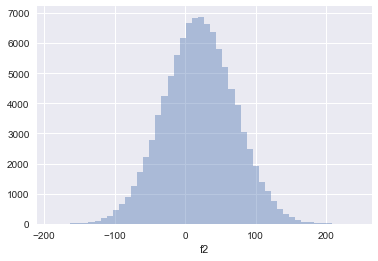

In [26]:
sns.distplot(df['f2'], kde=False)

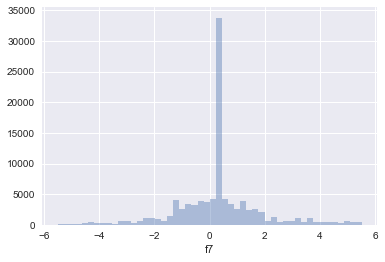

In [8]:
sns.distplot(df['f7'], kde=False)

#### I also observed the 'target' featuren, which is the label in our model. I found it a extremely imbalanced dataset, with too many positive class(target>=1000). Some solutions to handle this:
<br>1. To get more data of negative class (but not feasible in this case)<br/>
<br>2. Resampling: up/down sampleing the dataset to ensure almost equal representation for each class in training<br/>
<br>3. Weighting/Penalized: Some training algorithms such as tree-based algorithms can take instance weights are parameters. Attach higher weights to instances with less frequent labels.<br/>

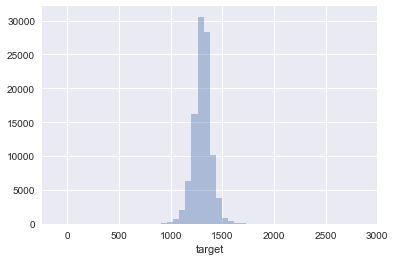

In [24]:
sns.distplot(df['target'], kde=False)

In [27]:
len(df[df.target < 1000])

227

#### Pearson Correlation to check collinearity among features, and some features are in high correlation coefficient. Some impacts of this will be:
<br>1. Hard to distinguish which feature is more importance to the result<br/>
<br>2. It will be unstable in a regression model if the testing data is in a different correlation.<br/>
#### In general, we don't have to take care of this problem. But if necessary, I can drop the less important feature in a high correlation,  use Penalized model, or use PCA or some other methods to extract features.

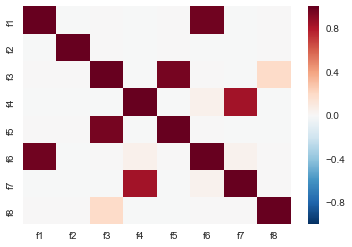

In [6]:
corr = df[['f1','f2','f3','f4','f5','f6','f7','f8']].corr()
sns.heatmap(corr)

## Define the problem and Model selection
#### According to the dataset, the problem can be treated as regressiong problem or classification problem, and I will do both methods.

#### K-Fold cross validation to evaluate the model.
<br>I used 5-fold cross-validation method to get the average accuracy of the random forest model.In k-fold cross-validation, the original sample is randomly partitioned into k equal sized subsamples. The advantage of this method over repeated random sub-sampling is that all observations are used for both training and validation, and each observation is used for validation exactly once. <br>

In [10]:
from sklearn.cross_validation import KFold

def run_cv(X,y,clf_class,**kwargs):
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    clf = clf_class(**kwargs)
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

C:\Users\Chiroy\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Regression Model
#### In this case, the regression model is used for simply predicting the target value, based on features to identify the product is defective of not. I used linear regression and ridge regression in addition as my model. The pros and cons are:
<br>Pros: Linear Regression is great if the data follow a linear trend or have a strong linear component<br/>
<br>Cons: Linear Regression is limited to linear relationships, so if the dataset is not in linear relationships, the model won't work well. And Linear Regression is sensitive to outliers<br/>
#### And the Ridge Regression is a Penalized model to reduce the impact of collinearity of features. According to this specific dataset, I will try this model as well

#### Downsampling datasets - with classes ratio of 1:2

In [73]:
df_neg = df[df.target < 1000]
df_pos = df[df.target >= 1000].sample(n=len(df_neg)*2)
df_new = df_neg.append(df_pos).sample(frac=1)
df_new = df_new.reset_index(drop=True)
df_new.head()

,f1,f2,f3,f4,f5,f6,f7,f8,target
0,17.735471,8.572519,20.861723,-1.903808,19.639279,13.466934,-1.903808,22.084168,973.415683
1,-6.112224,112.777920,24.749499,-0.901804,36.673347,1.643287,0.345671,12.825651,1177.091969
2,11.923848,12.467986,32.585170,0.701403,49.699399,10.821643,0.701403,15.470942,1290.467142
3,4.108216,39.749794,22.484970,-4.308617,30.160321,6.412826,-4.308617,14.809619,998.385759
4,22.945892,32.623211,19.098196,-1.503006,30.661323,16.112224,0.345671,7.535070,1255.201719


#### Data preprocessing - Standardization and dropping 'f7' feature

In [74]:
from sklearn.preprocessing import StandardScaler

X1 = df_new.drop('f7',axis=1)
X1 = X1.as_matrix().astype(float)
y1 = df_new['target']

scaler = StandardScaler()
X1 = scaler.fit_transform(X1)

#### Evaluation of models
<br>Both models perform similar in accuracy, but linear regression has lower root mean square error.<br/>

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

Ridge_CV_result = run_cv(X1,y1,Ridge) 
LR_CV_result = run_cv(X1,y1,LinearRegression)

def accuracy(y_true,y_pred):
    rms = np.sqrt(((y_true-y_pred)**2).mean())
    y_true = (y_true >= 1000)
    y_pred = (y_pred >= 1000)
    return [np.mean(y_true == y_pred),rms]

print ("Linear Regression Accuracy (evaluation): " + str(accuracy(y1, LR_CV_result)[0]) + ', RMS = ' + str(accuracy(y1, LR_CV_result)[1]))
print ("Ridge Accuracy (evaluation): " + str(accuracy(y1, Ridge_CV_result)[0]) + ', RMS = ' + str(accuracy(y1, Ridge_CV_result)[1]))

Linear Regression Accuracy (evaluation): 1.0, RMS = 2.97129124931e-13
Ridge Accuracy (evaluation): 1.0, RMS = 1.46598381482


#### Model Accuracy
<br>I collected testing data from the whole dataset (not from downsampled training dataset), and two models perform similar again. The F1-Score of linear regression is about 0.88. The recall is not as good as precision, this is because there are too many positive class data in the dataset, and we don't train enough positive class data. That is one of the impacts if we downsample the dataset.<br/>

In [76]:
X1_test = df.sample(n=int(0.2*len(df_new)))
y1_test = X1_test['target']
X1_test = X1_test.drop('f7',axis=1)
X1_test = X1_test.as_matrix().astype(float)
X1_test = scaler.fit_transform(X1_test)

LR = LinearRegression()
Rdg = Ridge()

LR.fit(X1, y1)
Rdg.fit(X1, y1)

y1_pred_LR = LR.predict(X1_test)
y1_pred_Rdg = Rdg.predict(X1_test)

print ("Linear Regression Accuracy: " + str(accuracy(y1_test, y1_pred_LR)[0]) + ', RMS = ' + str(accuracy(y1_test,y1_pred_LR)[1]))
print ("Ridge Accuracy: " + str(accuracy(y1_test, y1_pred_Rdg)[0]) + ', RMS = ' + str(accuracy(y1_test, y1_pred_Rdg)[1]))

Linear Regression Accuracy: 0.779411764706, RMS = 179.718929167
Ridge Accuracy: 0.779411764706, RMS = 178.915058464


In [81]:
tn, fp, fn, tp = confusion_matrix(y1_test>=1000, y1_pred_LR>=1000).ravel()
recall = tp / (tp + fn)
prec = tp / (tp + fp)
F1 = 2 * recall * prec / (recall + prec)
print('Recall = ', recall)
print('Precision = ', prec)
print('F1-Score = ', F1)

Recall =  0.779411764706
Precision =  1.0
F1-Score =  0.876033057851


### Classification Model
#### In this case, the target value will be transformed into label value first and training after that. I used Random Forest as my classification model, and the pros and cons are:
<br>Pros: Comparing to other classification model, Random forests are extremely flexible and have very high accuracy.And it works well in a high dimension feature map with missing value (assigned it as a specific value).Decision trees often perform well on imbalanced datasets. The splitting rules that look at the class variable used in the creation of the trees, can force both classes to be addressed. Also, it is not sensitive to linearity of features and outliers.<br/>
<br>Cons: The main disadvantage of Random forests is their complexity. They are much harder and time-consuming to construct than decision trees. They also require more computational resources and are also less intuitive. <br/>
#### According to this dataset, Random Forest would be a good choice for this classification problem.

#### Data preprocessing - Standardization and dropping 'f7' feature

In [82]:
from sklearn.preprocessing import StandardScaler

X = df.drop('f7',axis=1)
X = X.as_matrix().astype(float)

scaler = StandardScaler()
X = scaler.fit_transform(X)

#### Evaluation of models - adding weigt into training
<br>As the model is only trained on the normal/valid data, the majority class, the skewdness of the data is not the problem. For Random Forest, this imbalance has to be taken into account. One possible way would be to sample the data to get a more balanced dataset, another is the introduction of weighted cost for the classes.<br/>

In [83]:
y2 = df['target'] >= 1000

def accuracy2(y_true,y_pred):
    return np.mean(y_true == y_pred)

from sklearn.ensemble import RandomForestClassifier

RF_CV_result = run_cv(X,y2,RandomForestClassifier,class_weight = {0: 100000, 1: 1})
print("Random forest Accuracy (evaluation): " + str(accuracy2(y2, RF_CV_result)))

Random forest Accuracy (evaluation): 0.99999


#### Model Accuracy
<br>Although I adding a much higher weight to anormaly class, the model still perform well in the testing set(with train- test ratio of 7:3). One reason is the model is trained perfectly. Another reason is still, the data is imbalance, and adding more data will be better for furture prediction.<br/>

In [87]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y2,test_size=0.3)
RF = RandomForestClassifier(class_weight={0: 100000, 1: 1})
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
print("Random forest Accuracy: " + str(accuracy2(y_test, y_pred)))

Random forest Accuracy: 1.0


Random Forest
Accuracy is 1.0
Precision is 1.0
Recall is 1.0
F1-score is 1.0


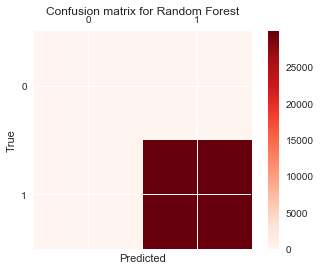

In [88]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def cal_evaluation(classifier, cm):
    tp = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tn = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print(classifier)
    print("Accuracy is " + str(accuracy))
    print("Precision is " + str(precision))
    print("Recall is " + str(recall))
    print("F1-score is " + str((2*precision*recall)/(precision+recall)))

def draw_confusion_matrices(confusion_matricies,class_names):
    class_names = class_names.tolist()
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    
y = np.array(y)
class_names = np.unique(y)

confusion_matrices = [
    ("Random Forest", confusion_matrix(y_test,y_pred)),
]

draw_confusion_matrices(confusion_matrices,class_names)

#### Importance of Features - Another Pros of Random Forest is, we can find which feature has more impact on final result
<br>And we could see, 'f8' has much higher importance than other features.<br/>

In [92]:
forest = RandomForestClassifier()
forest.fit(X, y2)

importances = forest.feature_importances_

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for k,v in sorted(zip(map(lambda x: round(x, 4), importances), df.columns), reverse=True):
    print(v + ": " + str(k))

Feature importance ranking by Random Forest Model:
f8: 0.9283
f4: 0.03
f7: 0.0221
f3: 0.009
f6: 0.0041
f1: 0.0031
f2: 0.0021
f5: 0.0014


### Anomaly Detection
#### Depending on this specific dataset, the problem can treated as a anomaly detection problem as well. There are many algorithm for Anomaly Detection: Density-based techniques like KNN, Clustering-Based techniques,SVM, Bayesian Networks, etc. So I will use KNN in this case.
<br>Pros: Very easy to understand and implement. Does not assume any probability distributions on the input data. Can quickly respond to changes in input(which is good for anomaly detection).<br/>
<br>Cons: Sensitive to localized data. And if in high dimensions, KNN may consider outliers in some dimensions as anomal data points.<br/>

#### Model Accuracy
<br>We could see KNN performed as good as Random Forest, with F1-Score of 1. But in genearl, Anomaly Detection may combine two predictive models (KNN and another one), in case of outliers in some dimensions and KNN may consider them as anomal data points.<br/>

In [95]:
from sklearn.neighbors import KNeighborsClassifier 

X = df.drop('f7',axis=1)
X = X.as_matrix().astype(float)
y2 = df['target'] >= 1000

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y2,test_size=0.3)
KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)
y_pred = RF.predict(X_test)
print("K-nearest Neighbors Accuracy: " + str(accuracy2(y_test, y_pred)))

K-nearest Neighbors Accuracy: 1.0


In [97]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
recall = tp / (tp + fn)
prec = tp / (tp + fp)
F1 = 2 * recall * prec / (recall + prec)
print('Recall = ', recall)
print('Precision = ', prec)
print('F1-Score = ', F1)

Recall =  1.0
Precision =  1.0
F1-Score =  1.0
